In [59]:
# 0. Import all libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import seaborn as sns

In [60]:
# 1. Import data
file_path = './data/AAPL_merged.csv'
data = pd.read_csv(file_path)

In [61]:
# 2. Preparing Data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.sort_index(ascending=True)

# Select columns needed to be kept
columns_to_keep = ['Open', 'High', 'Low', 'Close/Last', 'Volume', 'DPRIME', 'VIX_Close']
data = data[columns_to_keep]

# Subset data for the specified date range
start_date = '2014-06-24'
end_date = '2024-06-21'
data = data[(data.index >= start_date) & (data.index <= end_date)]

In [62]:
# 3. Descriptive statistics
print(data.describe())

              Open         High          Low   Close/Last        Volume  \
count  2516.000000  2516.000000  2516.000000  2516.000000  2.516000e+03   
mean     85.564357    86.484024    84.702970    83.597861  1.255896e+08   
std      58.881674    59.521504    58.293460    59.406120  7.188039e+07   
min      22.500000    22.674999    22.367500    19.963961  2.404834e+07   
25%      32.222499    32.443126    32.039375    28.968334  7.656813e+07   
50%      53.493749    54.152501    52.889149    51.340979  1.062418e+08   
75%     145.057499   146.954998   143.647530   143.641334  1.542644e+08   
max     217.589996   220.199997   213.000000   216.669998  7.593850e+08   

            DPRIME    VIX_Close  
count  2516.000000  2516.000000  
mean      4.659777    18.128164  
std       1.746143     7.310081  
min       3.250000     9.140000  
25%       3.250000    13.190000  
50%       4.000000    16.090000  
75%       5.500000    21.282501  
max       8.500000    82.690002  


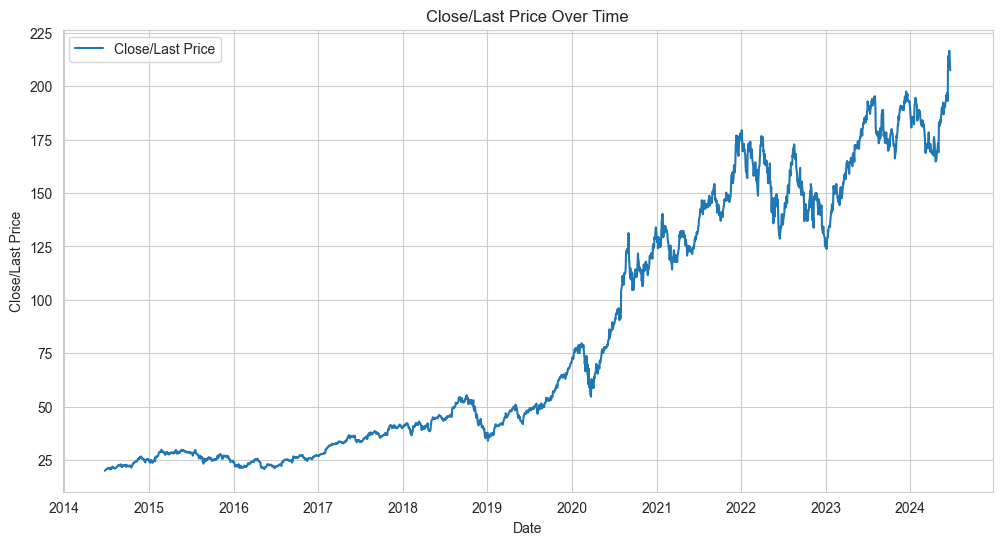

In [63]:
# 4. Visualizing the Close/Last price over time

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close/Last'], label='Close/Last Price')
plt.title('Close/Last Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close/Last Price')
plt.legend()
plt.show()


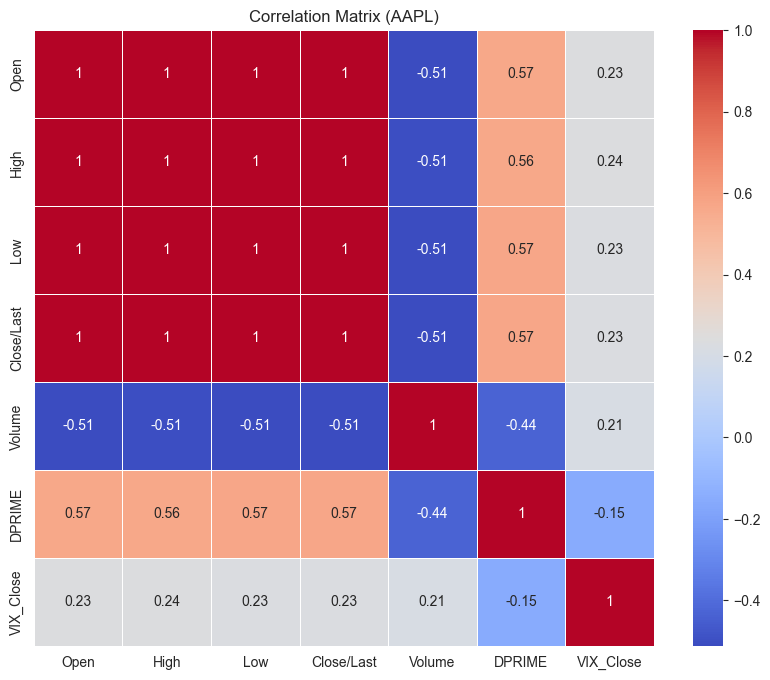

In [64]:
# 5. Correlation

# Correlation matrix
correlation_matrix = data.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix (AAPL)')
plt.show()


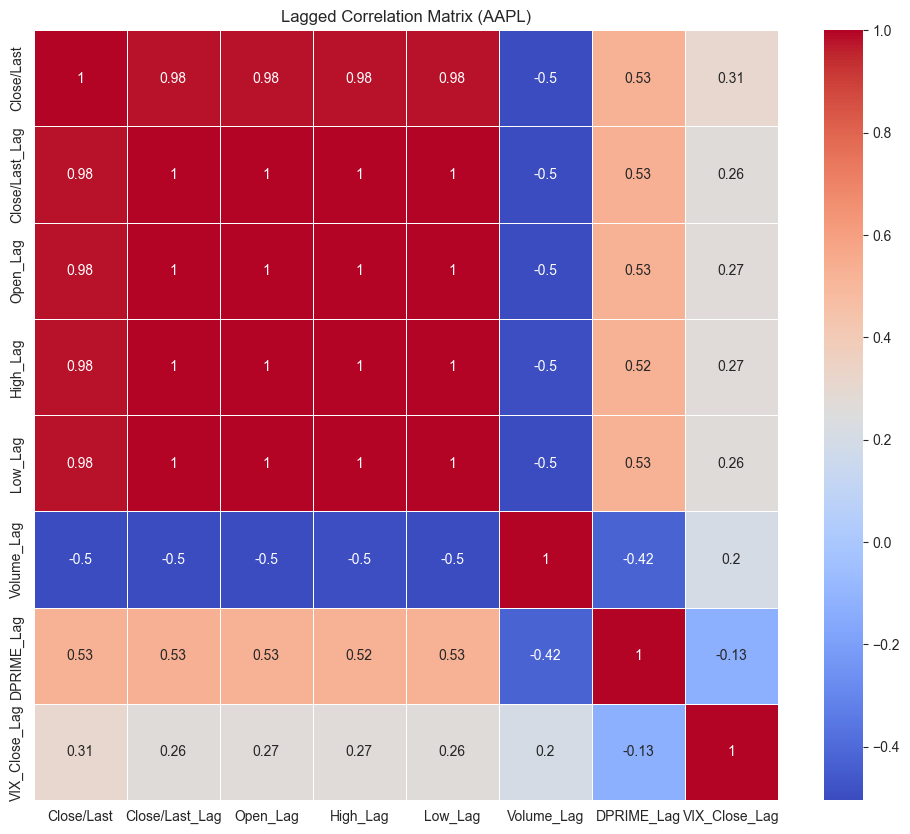

In [65]:
# lagged correlation

data_lag = data.copy()

data_lag['Close/Last_Lag'] = data_lag['Close/Last'].shift(60)
data_lag['Open_Lag'] = data_lag['Open'].shift(60)
data_lag['High_Lag'] = data_lag['High'].shift(60)
data_lag['Low_Lag'] = data_lag['Low'].shift(60)
data_lag['Volume_Lag'] = data_lag['Volume'].shift(60)
data_lag['DPRIME_Lag'] = data_lag['DPRIME'].shift(60)
data_lag['VIX_Close_Lag'] = data_lag['VIX_Close'].shift(60)

data_lag = data_lag.dropna()

# 4. 选择需要计算相关性的列
columns_to_correlate = ['Close/Last', 'Close/Last_Lag', 'Open_Lag', 'High_Lag', 'Low_Lag', 'Volume_Lag', 'DPRIME_Lag', 'VIX_Close_Lag']
data_lag = data_lag[columns_to_correlate]

lagged_correlation_matrix = data_lag.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(lagged_correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Lagged Correlation Matrix (AAPL)')
plt.show()

<Figure size 1000x600 with 0 Axes>

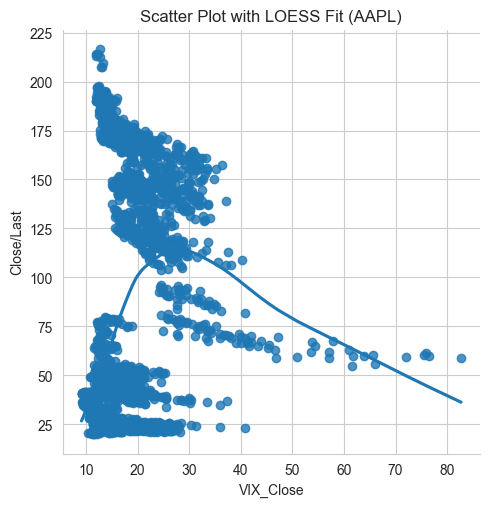

In [66]:
# recognize non-linear pattern

plt.figure(figsize=(10, 6))
sns.lmplot(x='VIX_Close', y='Close/Last', data=data, lowess=True)
plt.title('Scatter Plot with LOESS Fit (AAPL)')
plt.show()


<Figure size 1000x600 with 0 Axes>

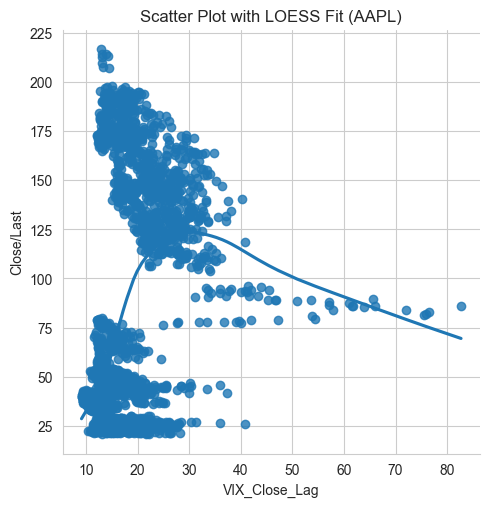

In [67]:

plt.figure(figsize=(10, 6))
sns.lmplot(x='VIX_Close_Lag', y='Close/Last', data=data_lag, lowess=True)
plt.title('Scatter Plot with LOESS Fit (AAPL)')
plt.show()


In [68]:
# 6. Feature Engineering

data_fe = data.copy()

# 特征工程：添加移动平均
data_fe['MA_10'] = data_fe['Close/Last'].rolling(window=10).mean()
data_fe['MA_50'] = data_fe['Close/Last'].rolling(window=50).mean()

# 特征工程：添加滞后特征
data_fe['Lag_1'] = data_fe['Close/Last'].shift(1)
data_fe['Lag_5'] = data_fe['Close/Last'].shift(5)
data_fe['Lag_30'] = data_fe['Close/Last'].shift(30)
data_fe['Lag_60'] = data_fe['Close/Last'].shift(60)
data_fe['Lag_90'] = data_fe['Close/Last'].shift(90)

# 删除因移动平均和滞后特征生成的 NaN 行
data_fe.dropna(inplace=True)

<Figure size 1200x600 with 0 Axes>

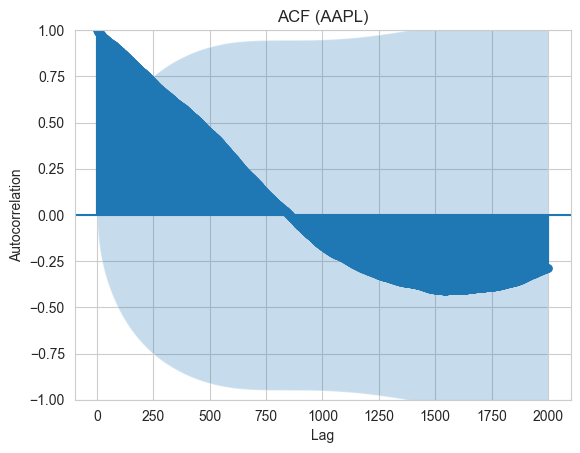

In [69]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

# 计算自相关函数（ACF）
plt.figure(figsize=(12, 6))
plot_acf(data['Close/Last'], lags=2000)
plt.title('ACF (AAPL)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

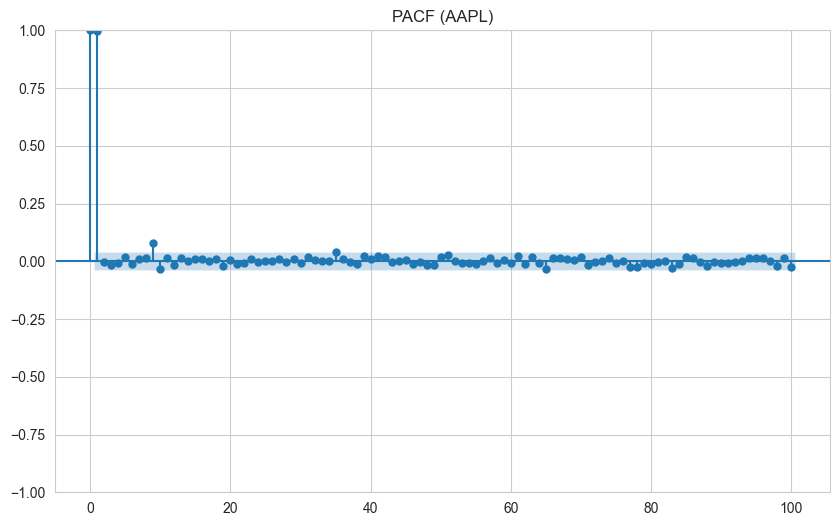

In [70]:
# 2. 计算并绘制 PACF
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(10, 6))
plot_pacf(data['Close/Last'].dropna(), lags=100, ax=plt.gca(), method='ywm')
plt.title('PACF (AAPL)')
plt.show()

In [71]:
# ACF, Autocorrelation Function
# 计算自相关系数
acf_values = acf(data['Close/Last'], nlags=100)

# 打印特定滞后期的自相关系数
print(f"Lag 30: {acf_values[30]}")
print(f"Lag 60: {acf_values[60]}")
print(f"Lag 90: {acf_values[90]}")


Lag 30: 0.9584225309588387
Lag 60: 0.9289927310600384
Lag 90: 0.9001846013699782


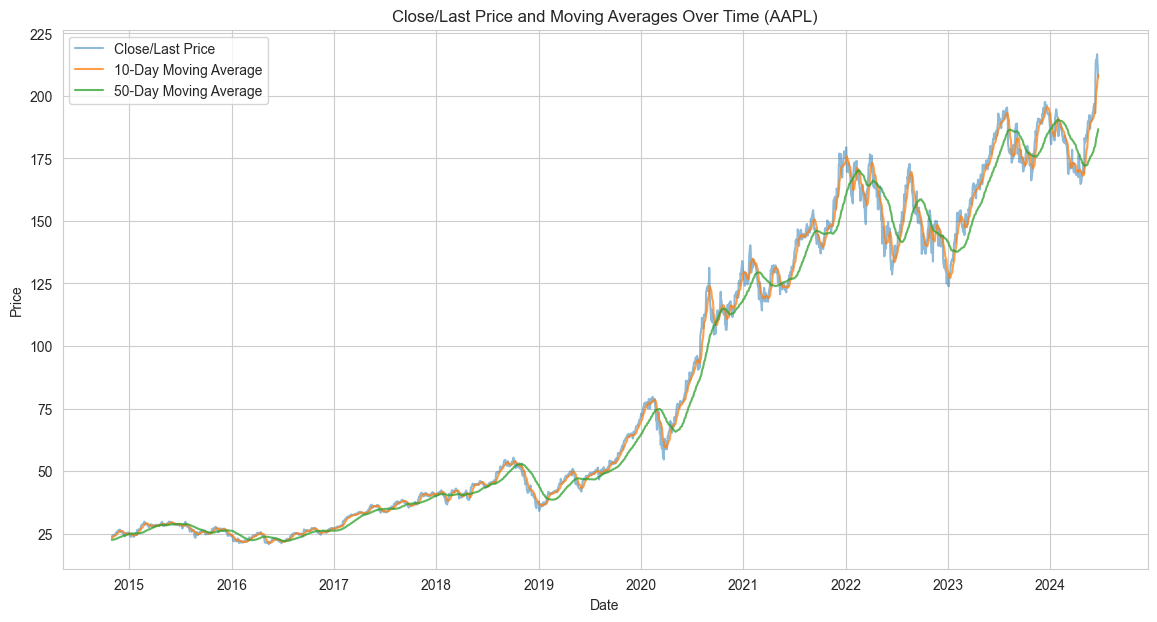

In [72]:
# 6.1  Plotting the Close/Last price with moving averages
plt.figure(figsize=(14, 7))
plt.plot(data_fe.index, data_fe['Close/Last'], label='Close/Last Price', alpha=0.5)
plt.plot(data_fe.index, data_fe['MA_10'], label='10-Day Moving Average', alpha=0.75)
plt.plot(data_fe.index, data_fe['MA_50'], label='50-Day Moving Average', alpha=0.75)
plt.title('Close/Last Price and Moving Averages Over Time (AAPL)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


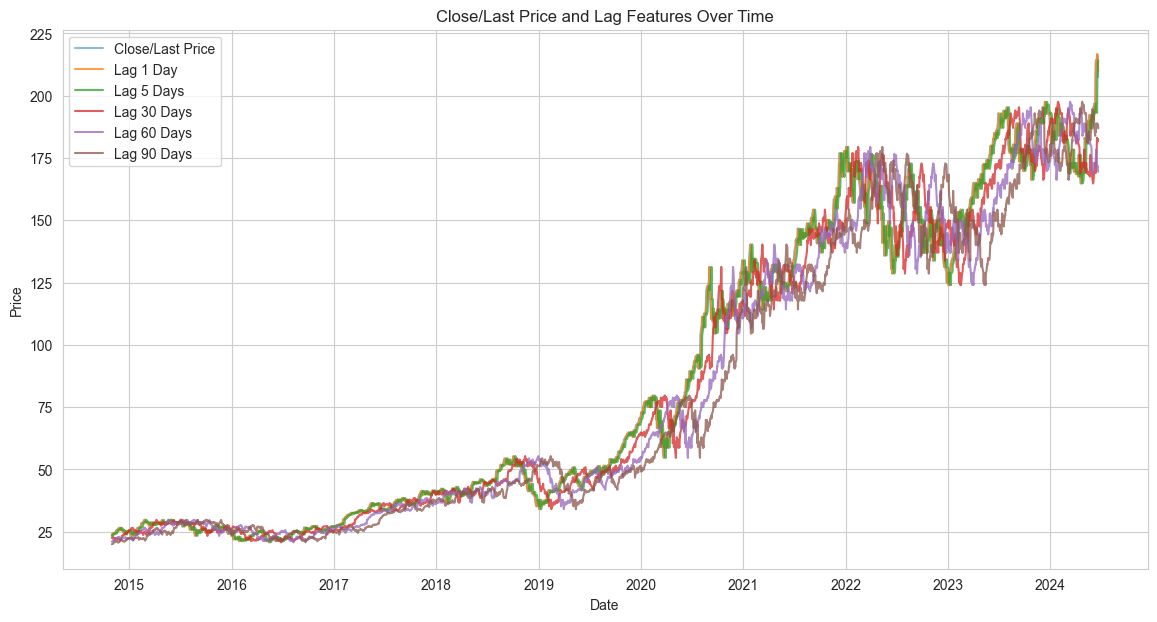

In [74]:
# 6.2 Plotting the Close/Last price with lag features
plt.figure(figsize=(14, 7))
plt.plot(data_fe.index, data_fe['Close/Last'], label='Close/Last Price', alpha=0.5)
plt.plot(data_fe.index, data_fe['Lag_1'], label='Lag 1 Day', alpha=0.75)
plt.plot(data_fe.index, data_fe['Lag_5'], label='Lag 5 Days', alpha=0.75)
plt.plot(data_fe.index, data_fe['Lag_30'], label='Lag 30 Days', alpha=0.75)
plt.plot(data_fe.index, data_fe['Lag_60'], label='Lag 60 Days', alpha=0.75)
plt.plot(data_fe.index, data_fe['Lag_90'], label='Lag 90 Days', alpha=0.75)
plt.title('Close/Last Price and Lag Features Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

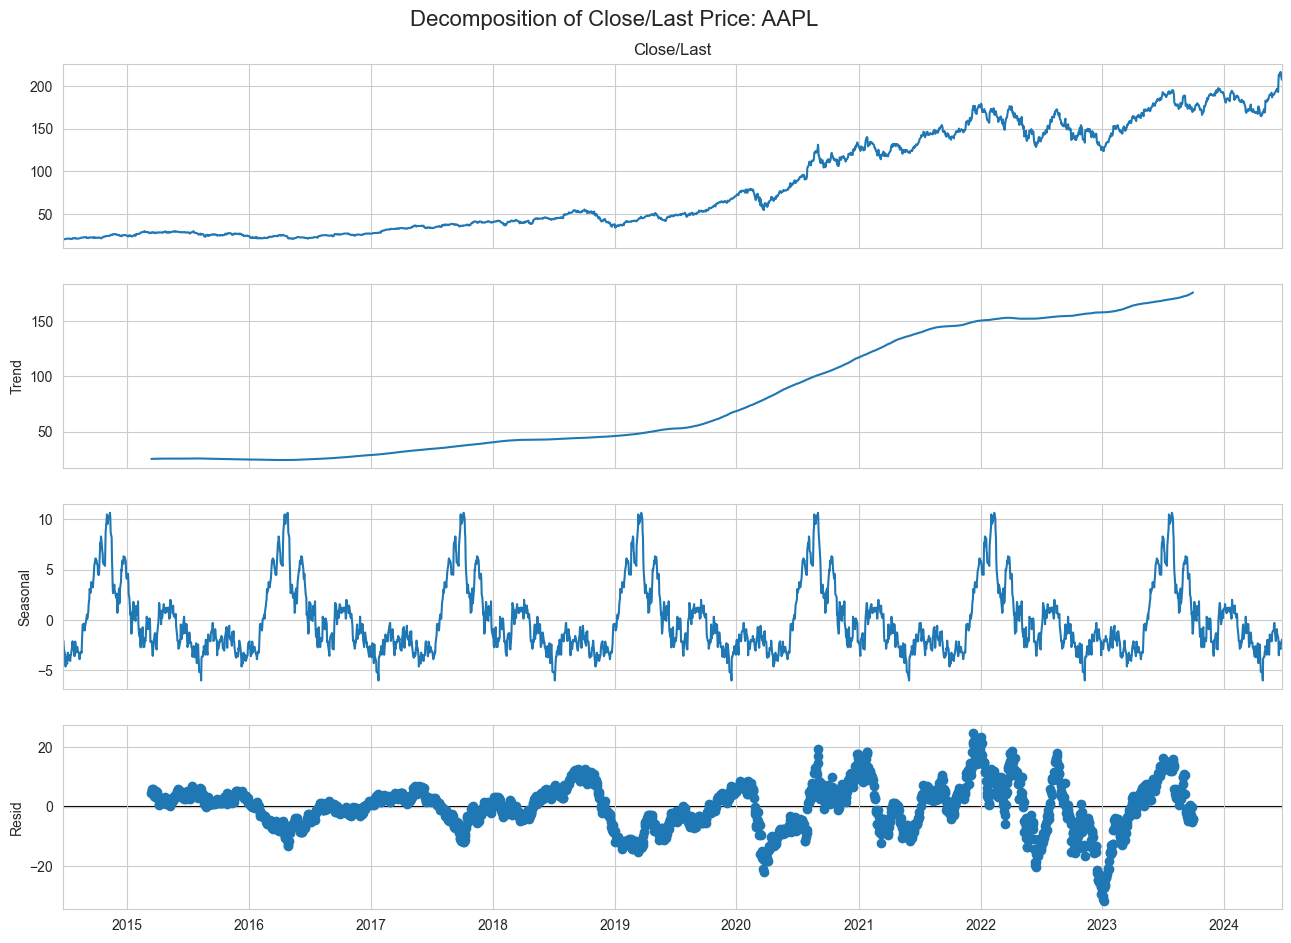

In [75]:
import statsmodels.api as sm

# 7. Decompose the time series to observe trend, seasonality, and residuals
decomposition = sm.tsa.seasonal_decompose(data['Close/Last'], model='additive', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle('Decomposition of Close/Last Price: AAPL', fontsize=16)

plt.show()


In [76]:
# Save each component to a DataFrame
trend_df = pd.DataFrame({'Date': trend.index, 'Trend': trend.values}).dropna()
seasonal_df = pd.DataFrame({'Date': seasonal.index, 'Seasonal': seasonal.values}).dropna()
residual_df = pd.DataFrame({'Date': residual.index, 'Residual': residual.values}).dropna()

# # Print the first few rows of each DataFrame
# print("Trend DataFrame:")
# print(trend_df.head())
# print("\nSeasonal DataFrame:")
# print(seasonal_df.head())
# print("\nResidual DataFrame:")
# print(residual_df.head())

In [77]:
# 7.1 Trend Component: Calculate the slope
trend.dropna(inplace=True)  # Drop NaN values
X = np.arange(len(trend)).reshape(-1, 1)
y = trend.values
model = LinearRegression().fit(X, y)
slope = model.coef_[0]
print(f"Trend Slope: {slope}")

# 7.2 Seasonal Component: Calculate the amplitude
seasonal_max = seasonal.max()
seasonal_min = seasonal.min()
amplitude = seasonal_max - seasonal_min
print(f"Seasonal Amplitude: {amplitude}")

# 7.3 Residual Component: Calculate the standard deviation
residual_std = residual.std()
print(f"Residual Standard Deviation: {residual_std}")

Trend Slope: 0.08138334992388177
Seasonal Amplitude: 16.67157560684932
Residual Standard Deviation: 7.640937439168507


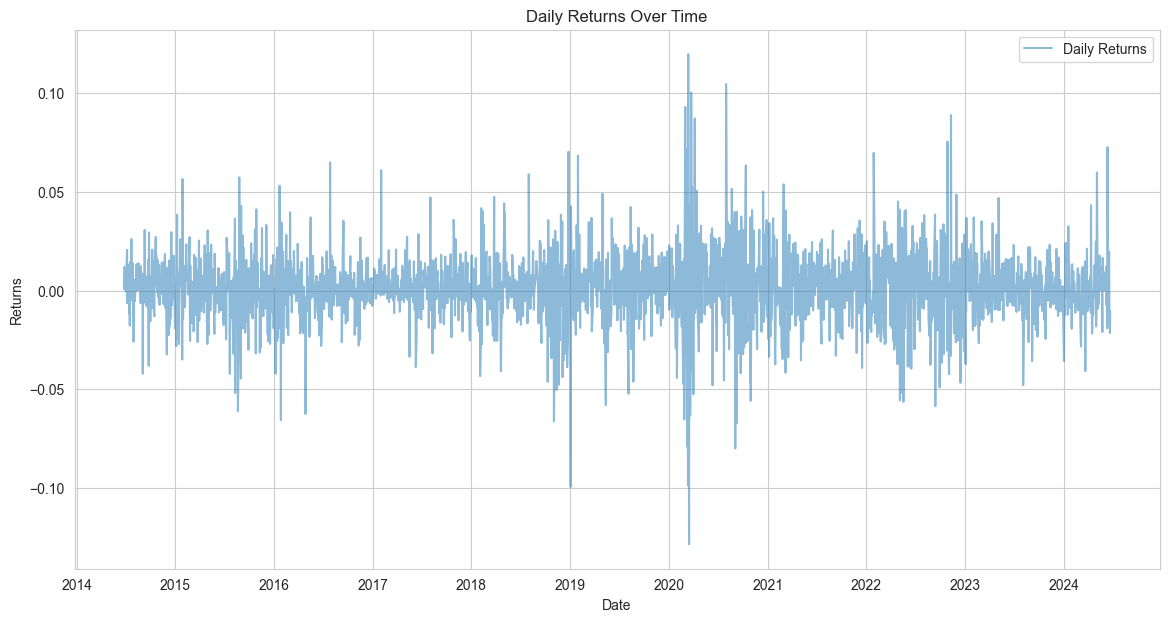

In [78]:
# Calculate the daily returns
data['Daily_Returns'] = data['Close/Last'].pct_change()

# Plotting the daily returns
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Daily_Returns'], label='Daily Returns', alpha=0.5)
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()


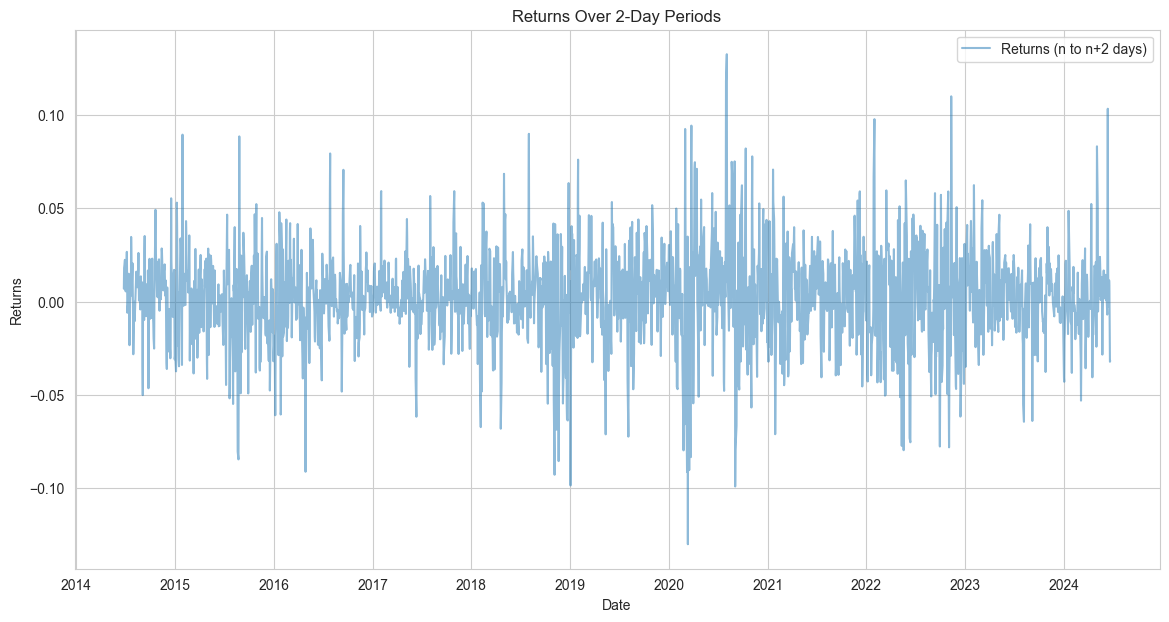

In [79]:
# Calculate the returns between n and n+2 days
data['Returns_n_to_n+2'] = data['Close/Last'].pct_change(periods=2)

# Plotting the n to n+2 day returns
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Returns_n_to_n+2'], label='Returns (n to n+2 days)', alpha=0.5)
plt.title('Returns Over 2-Day Periods')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

Returns (n to n+10 days) Metrics:
Mean Return: 0.011084453273817147
Standard Deviation: 0.05475516617480551
Annualized Return: 15.085442624249719
Sharpe Ratio: 3.213582443126253

Returns (n to n+30 days) Metrics:
Mean Return: 0.03324473629230801
Standard Deviation: 0.10085189244150802
Annualized Return: 3793.9563164897922
Sharpe Ratio: 5.2328599395822275

Returns (n to n+365 days) Metrics:
Mean Return: 0.45060808344068404
Standard Deviation: 0.45813504047822784
Annualized Return: 5.135981971612459e+40
Sharpe Ratio: 15.6136966903253


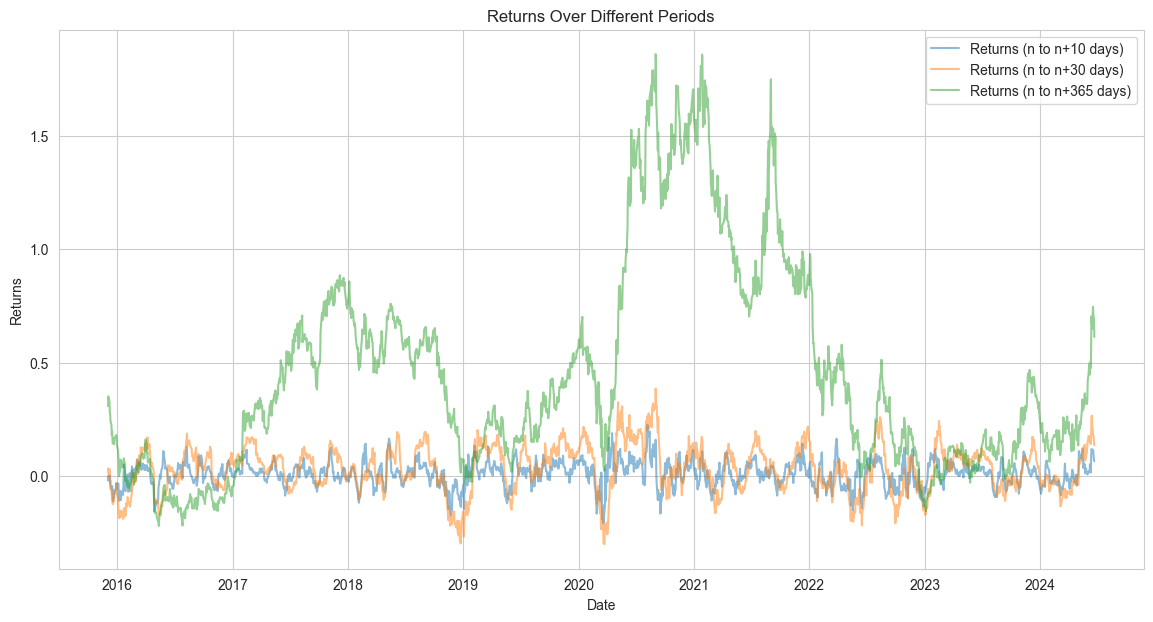

In [80]:
# Calculate returns for different periods
data['Returns_n_to_n+10'] = data['Close/Last'].pct_change(periods=10)
data['Returns_n_to_n+30'] = data['Close/Last'].pct_change(periods=30)
data['Returns_n_to_n+365'] = data['Close/Last'].pct_change(periods=365)

# Drop NaN values
data.dropna(inplace=True)

# Define a function to calculate performance metrics
def calculate_performance_metrics(returns, risk_free_rate=0.0):
    mean_return = returns.mean()
    std_dev = returns.std()
    annualized_return = ((1 + mean_return) ** 252) - 1  # Assuming 252 trading days in a year
    sharpe_ratio = (mean_return - risk_free_rate) / std_dev * np.sqrt(252)
    
    return {
        "Mean Return": mean_return,
        "Standard Deviation": std_dev,
        "Annualized Return": annualized_return,
        "Sharpe Ratio": sharpe_ratio
    }

# Calculate metrics for n to n+10 day returns
n_to_n_plus_10_metrics = calculate_performance_metrics(data['Returns_n_to_n+10'])

# Calculate metrics for n to n+30 day returns
n_to_n_plus_30_metrics = calculate_performance_metrics(data['Returns_n_to_n+30'])

# Calculate metrics for n to n+365 day returns
n_to_n_plus_365_metrics = calculate_performance_metrics(data['Returns_n_to_n+365'])

# Print the performance metrics
print("Returns (n to n+10 days) Metrics:")
for key, value in n_to_n_plus_10_metrics.items():
    print(f"{key}: {value}")

print("\nReturns (n to n+30 days) Metrics:")
for key, value in n_to_n_plus_30_metrics.items():
    print(f"{key}: {value}")

print("\nReturns (n to n+365 days) Metrics:")
for key, value in n_to_n_plus_365_metrics.items():
    print(f"{key}: {value}")

# Plotting the returns for visualization
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Returns_n_to_n+10'], label='Returns (n to n+10 days)', alpha=0.5)
plt.plot(data.index, data['Returns_n_to_n+30'], label='Returns (n to n+30 days)', alpha=0.5)
plt.plot(data.index, data['Returns_n_to_n+365'], label='Returns (n to n+365 days)', alpha=0.5)
plt.title('Returns Over Different Periods')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [81]:
data

,Open,High,Low,Close/Last,Volume,DPRIME,VIX_Close,Daily_Returns,Returns_n_to_n+2,Returns_n_to_n+10,Returns_n_to_n+30,Returns_n_to_n+365
Date,,,,,,,,,,,,
2015-12-03,29.137501,29.197500,28.555000,26.150436,166278036,3.25,18.110001,-0.009288,-0.018238,-0.017819,0.016993,0.309882
2015-12-04,28.822500,29.812500,28.777500,27.019846,231107908,3.25,14.810000,0.033246,0.023650,0.002105,0.034974,0.352233
2015-12-07,29.745001,29.965000,29.452499,26.849588,128336996,3.25,15.840000,-0.006301,0.026736,-0.008550,-0.002467,0.335729
2015-12-08,29.379999,29.650000,29.215000,26.838247,137237800,3.25,17.600000,-0.000422,-0.006721,0.004076,0.029980,0.319489
2015-12-09,29.410000,29.422501,28.770000,26.245777,185445428,3.25,19.610001,-0.022076,-0.022489,-0.027423,0.013661,0.277169
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,213.850006,215.169998,211.300003,212.490005,70122748,8.50,12.660000,-0.008168,-0.002722,0.105280,0.229719,0.648892
2024-06-17,213.369995,218.949997,212.720001,216.669998,93728300,8.50,12.750000,0.019671,0.011342,0.116683,0.183138,0.746662
2024-06-18,217.589996,218.630005,213.000000,214.289993,79943254,8.50,12.300000,-0.010984,0.008471,0.102598,0.180896,0.709840


============

In [82]:
time_steps = 90

In [83]:
# Split data
total_length = len(data)
train_length = int(total_length * 0.70)
train_set = data.iloc[:train_length].copy()
valid_set = data.iloc[train_length:].copy()


In [84]:
def train_and_evaluate_lstm(data, target_column):
    # Set index and sort data
    data.set_index('Date', inplace=True)
    data = data.sort_index(ascending=True)
    
    # Split data
    total_length = len(data)
    train_length = int(total_length * 0.70)
    train_set = data.iloc[:train_length].copy()
    valid_set = data.iloc[train_length:].copy()
    
    # Data pre-processing
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data = scaler.fit_transform(train_set[target_column].values.reshape(-1, 1))
    valid_data = scaler.transform(valid_set[target_column].values.reshape(-1, 1))
    
    # Initialize lists to store training and validation data
    x_train, y_train = [], []
    for i in range(time_steps, len(train_data)):
        x_train.append(train_data[i-time_steps:i, 0])
        y_train.append(train_data[i, 0])
    
    x_valid, y_valid = [], []
    for i in range(time_steps, len(valid_data)):
        x_valid.append(valid_data[i-time_steps:i, 0])
        y_valid.append(valid_data[i, 0])
    
    # Convert lists to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_valid, y_valid = np.array(x_valid), np.array(y_valid)
    x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
    
    # Build Model
    def build_model():
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model
    
    # Training
    model = build_model()
    model.fit(x_train, y_train, epochs=25, batch_size=32)
    
    # Make Prediction
    predicted_y_valid_normalized = model.predict(x_valid)
    predicted_y_valid = scaler.inverse_transform(predicted_y_valid_normalized)
    
    # Print & Visualize the results
    valid_rmse = np.sqrt(mean_squared_error(valid_set[target_column].values[time_steps:], predicted_y_valid))
    print(f"LSTM RMSE on validation set for {target_column}: {valid_rmse}")
    
    plt.figure(figsize=(14, 7))
    plt.plot(train_set.index, train_set[target_column], label='Training Data')
    plt.plot(valid_set.index[time_steps:], valid_set[target_column].values[time_steps:], label='Validation Data')
    plt.plot(valid_set.index[time_steps:], predicted_y_valid, label='Validation Predictions')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title(f'Stock Price Prediction with LSTM ({target_column} Part)')
    plt.legend()
    plt.show()

Epoch 1/25


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0433
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0020
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0011
Epoch 4/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0014
Epoch 5/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0025
Epoch 6/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0012
Epoch 7/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0012
Epoch 8/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0011
Epoch 9/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0011
Epoch 10/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 9.7705e-04
Epoch 11/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 8.9052e-04
Epoch 12/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 8.5723e-04
Epoch 13/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0012
Epoch 14/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 8.0189e-04
Epoch 15/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0011

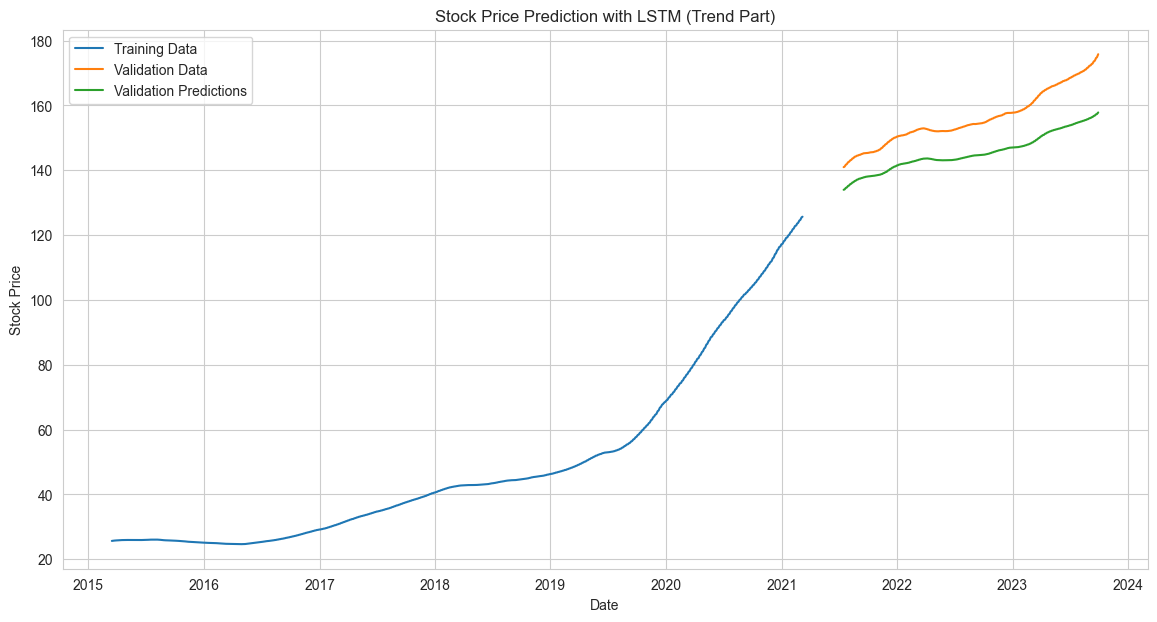

In [85]:
# Options of dataframe
# dataframes = {'Trend': trend_df, 'Seasonal': seasonal_df, 'Residual': residual_df}

train_and_evaluate_lstm(trend_df, 'Trend')

Epoch 1/25


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0558
Epoch 2/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0109
Epoch 3/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0102
Epoch 4/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0076
Epoch 5/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0082
Epoch 6/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0066
Epoch 7/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0059
Epoch 8/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0059
Epoch 9/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0058
Epoch 10/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0050
Epoch 11/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0060
Epoch 12/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0053
Epoch 13/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0053
Epoch 14/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0055
Epoch 15/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0049
Epoch 16/25
53/

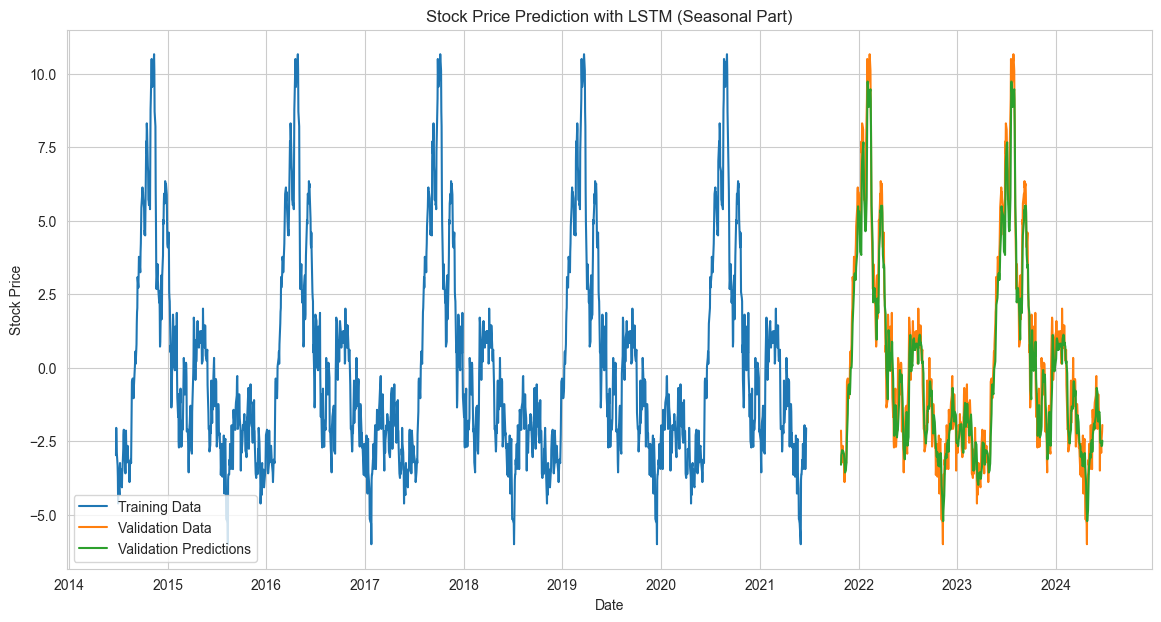

In [86]:
train_and_evaluate_lstm(seasonal_df, 'Seasonal')

Epoch 1/25


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0724
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0079
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0067
Epoch 4/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0062
Epoch 5/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0060
Epoch 6/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0056
Epoch 7/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0056
Epoch 8/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0056
Epoch 9/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0050
Epoch 10/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0043
Epoch 11/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0041
Epoch 12/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0047
Epoch 13/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0044
Epoch 14/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0047
Epoch 15/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0042
Epoch 16/25
45/

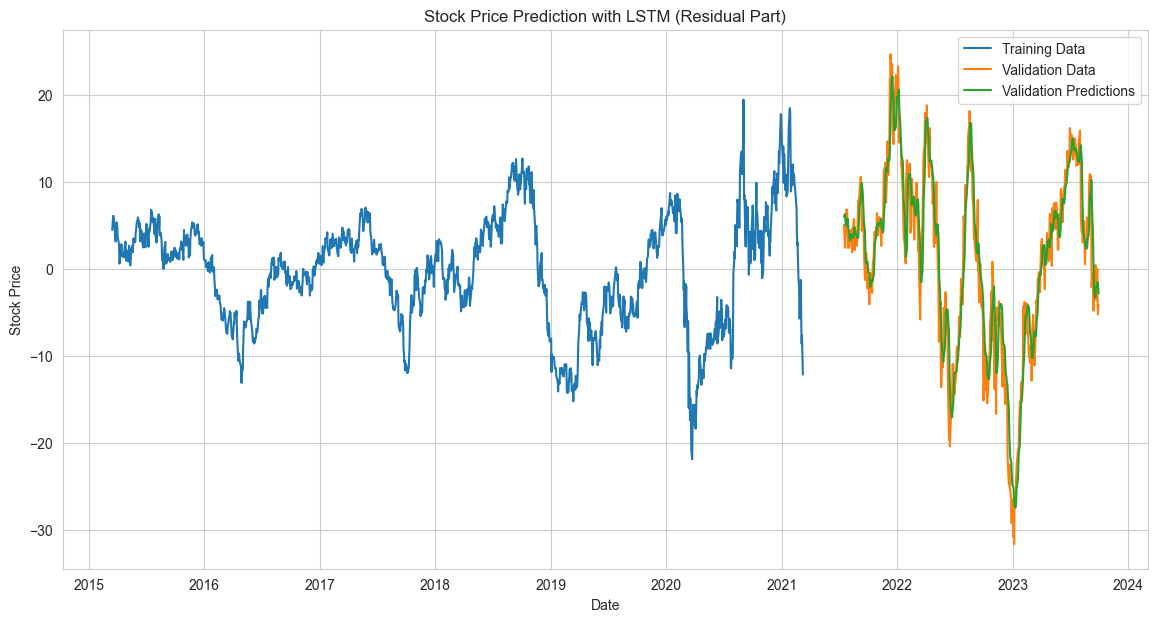

In [87]:
train_and_evaluate_lstm(residual_df, 'Residual')